In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
%matplotlib inline

In [3]:
img = cv2.imread('clocks/clock2.png')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [4]:
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
kp1, des1 = sift.detectAndCompute(gray,None)
img=cv2.drawKeypoints(gray,kp1,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

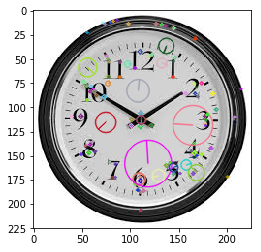

In [5]:
plt.imshow(img, cmap='gray')

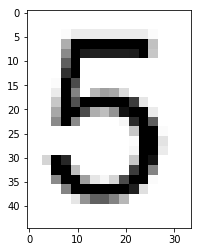

In [6]:
num2 = cv2.cvtColor(cv2.imread('clocks/num5.png'), cv2.COLOR_BGR2GRAY)
plt.imshow(num2, cmap='gray')

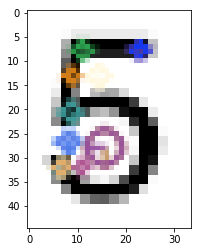

In [7]:
sift2 = cv2.xfeatures2d.SIFT_create()
kp2, des2 = sift2.detectAndCompute(num2,None)
img2=cv2.drawKeypoints(num2,kp2,num2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2, cmap='gray')

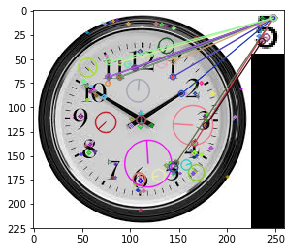

(<matplotlib.image.AxesImage at 0x1185dad90>, None)

In [8]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
# Match descriptors.
matches = bf.match(des1,des2)
#Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# # Apply ratio test
# good = []
# for m,n in matches:
#     if m.distance < 0.75*n.distance:
#         good.append([m])
# Draw first 10 matches.
img3 = cv2.drawMatches(img,kp1,img2,kp2,matches[:15], None,flags=2)
plt.imshow(img3),plt.show()

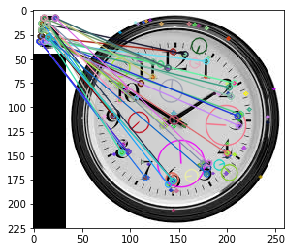

(<matplotlib.image.AxesImage at 0x118692a90>, None)

In [9]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des2,des1, k=3)
# Apply ratio test
good = []
for pts in matches:
#     if m.distance < 0.75*n.distance:
    good.append([x for x in pts if x.distance < pts[0].distance * 1.3])
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img2,kp2,img,kp1,good,None,flags=2)
plt.imshow(img3),plt.show()

In [10]:
good

[[<DMatch 0x115c960b0>, <DMatch 0x115c96170>, <DMatch 0x115c961d0>],
 [<DMatch 0x115c961f0>, <DMatch 0x118352bb0>, <DMatch 0x118352bd0>],
 [<DMatch 0x118352bf0>, <DMatch 0x118352a90>, <DMatch 0x118352cf0>],
 [<DMatch 0x118352c10>, <DMatch 0x118352530>, <DMatch 0x118352ed0>],
 [<DMatch 0x118352f30>, <DMatch 0x118352d90>, <DMatch 0x118352450>],
 [<DMatch 0x118352eb0>, <DMatch 0x118352ef0>, <DMatch 0x1183527b0>],
 [<DMatch 0x1183526f0>],
 [<DMatch 0x118352dd0>, <DMatch 0x118352470>, <DMatch 0x118352db0>],
 [<DMatch 0x118352770>, <DMatch 0x1183526d0>, <DMatch 0x1183523f0>],
 [<DMatch 0x118352a70>, <DMatch 0x1183529b0>, <DMatch 0x118352cd0>],
 [<DMatch 0x118352990>, <DMatch 0x118352790>, <DMatch 0x118352d10>],
 [<DMatch 0x118352630>, <DMatch 0x118352910>, <DMatch 0x118352df0>],
 [<DMatch 0x118352610>]]

In [11]:
from collections import defaultdict
def extract_matches(match_list_matrix, kp_1, kp_2):
    result = defaultdict(list)
    if len(match_list_matrix):
        if isinstance(match_list_matrix[0], list):
            for dmatch_list in match_list_matrix:
                for dmatch in dmatch_list:
                    #print(dmatch.trainIdx)
                    result[kp_2[dmatch.trainIdx]].append(dmatch)
        else:
            for dmatch in match_list_matrix:
                result[kp_2[dmatch.trainIdx]].append(dmatch)
    return result

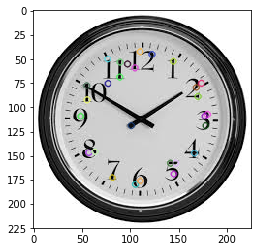

(<matplotlib.image.AxesImage at 0x115e0bf50>, None)

In [12]:
result = extract_matches(good, kp2, kp1)
img4=cv2.drawKeypoints(gray,result.keys(), None)
plt.imshow(img4),plt.show()

In [13]:
good_matched_kp = sorted(result.keys(), key=lambda x: min([dmatch.distance for dmatch in result[x]]))[:20]

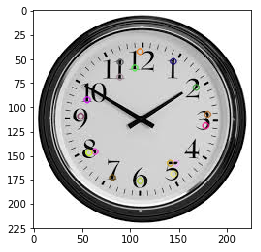

(<matplotlib.image.AxesImage at 0x115f1ae10>, None)

In [14]:
img5=cv2.drawKeypoints(gray,good_matched_kp, None)
plt.imshow(img5),plt.show()

In [15]:
len(good_matched_kp)

20

In [16]:
import pickle
contours = pickle.load(open('contours.pk'))

In [17]:
from collections import defaultdict
bb_map = defaultdict(int)
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    bb_map[(x, y, w, h)] = 0

In [18]:
for good_kp in good_matched_kp:
    x_, y_ = good_kp.pt
    for x, y,  w, h in bb_map:
        if x_ >= x and x_ <= x + w and y_ >= y and y_ <= y + h:
            #print('aha')
            bb_map[(x, y, w, h)] += 1

In [30]:
candidate_bb = []
for bb, score in sorted(bb_map.items(), key=lambda x: -x[1]):
    x, y, w, h = bb
    if max(w, h) > max(img.shape)/3 or not score:
        continue
    candidate_bb.append(bb)
#     if len(candidate_bb) > 10:
#         break

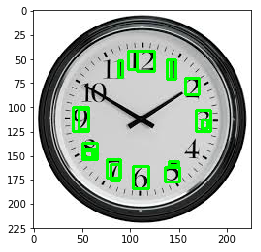

In [31]:
img = cv2.imread('clocks/clock2.png')
for x, y, w, h in candidate_bb:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(img)
plt.show()

In [32]:
# return positive number if there's overlap, o/w return negative number of their distance
def overlap_bw_segment(line1, line2):
    a1, a2 = line1
    b1, b2 = line2
    if a2 <= b1:
        return a2 - b1
    if a1 >= b2:
        return b2 - a1
    return min(a2, b2) - max(a1, b1)
    
def merge_bb(bb_list, overlap_ratio=0.6):
    while True:
        merged_idx = set()
        new_bb_list = []
        for i in range(len(bb_list)):
            if i in merged_idx: continue
            for j in range(i, len(bb_list)):
                if j in merged_idx: continue
                x1, y1, w1, h1 = bb_list[i]
                x2, y2, w2, h2 = bb_list[j]
                x_overlap = overlap_bw_segment((x1, x1+w1), (x2, x2+w2))
                if x_overlap > -(1-overlap_ratio) * min(w1, w2):
                    y_overlap = overlap_bw_segment((y1, y1+h1), (y2, y2+h2))
                    if y_overlap > -(1-overlap_ratio) * min(h1, h2):
                        if x_overlap >= overlap_ratio * min(w1, w2) or y_overlap >= overlap_ratio * min(h1, h2):
                            merged_idx.add(i)
                            merged_idx.add(j)
                            new_x = min(x1, x2)
                            new_y = min(y1, y2)
                            new_bb_list.append((new_x, new_y, ))

19

In [33]:
candidate_bb

[(53, 143, 11, 9),
 (51, 137, 15, 17),
 (47, 102, 10, 21),
 (41, 100, 16, 25),
 (88, 52, 4, 17),
 (103, 161, 16, 23),
 (140, 156, 10, 5),
 (168, 103, 15, 22),
 (140, 156, 10, 4),
 (107, 42, 18, 21),
 (142, 51, 5, 20),
 (80, 159, 9, 17),
 (76, 154, 14, 19),
 (138, 51, 9, 20),
 (98, 42, 9, 19),
 (51, 145, 10, 9),
 (136, 162, 15, 15),
 (157, 70, 14, 17),
 (174, 113, 6, 9)]